In [1]:
!pip install --upgrade quantecon

  Using cached quantecon-0.4.8-py3-none-any.whl (230 kB)


In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
α = 4.0

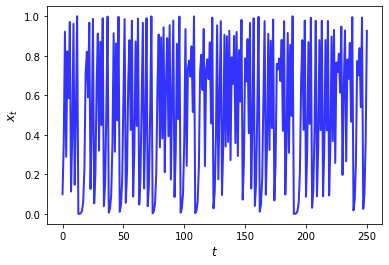

In [4]:
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0 
    for t in range(n):
      x[t+1] = α * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

In [5]:
from numba import jit

qm_numba = jit(qm)  

In [6]:
n = 10_000_000

qe.tic()
qm(0.1, int(n))
time1 = qe.toc()

TOC: Elapsed: 0:00:10.54


In [7]:
qe.tic()
qm_numba(0.1, int(n))
time2 = qe.toc()

TOC: Elapsed: 0:00:0.19


In [8]:
qe.tic()
qm_numba(0.1, int(n))
time3 = qe.toc()

TOC: Elapsed: 0:00:0.07


In [9]:
time1 / time3  # Calculate speed gain

139.15790699137878

In [10]:
qm_numba = jit(qm)  

In [11]:
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    return x

In [12]:
qm(0.1, 10)

array([0.1       , 0.36      , 0.9216    , 0.28901376, 0.82193923,
       0.58542054, 0.97081333, 0.11333925, 0.40197385, 0.9615635 ,
       0.14783656])

In [13]:
from numba import njit

@njit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

In [14]:
from numba import jitclass, float64

In [15]:
solow_data = [
    ('n', float64),
    ('s', float64),
    ('δ', float64),
    ('α', float64),
    ('z', float64),
    ('k', float64)
]

@jitclass(solow_data)
class Solow:
    r"""
    Implements the Solow growth model with the update rule

        k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)

    """
    def __init__(self, n=0.05,  # population growth rate
                       s=0.25,  # savings rate
                       δ=0.1,   # depreciation rate
                       α=0.3,   # share of labor
                       z=2.0,   # productivity
                       k=1.0):  # current capital stock

        self.n, self.s, self.δ, self.α, self.z = n, s, δ, α, z
        self.k = k

    def h(self):
        "Evaluate the h function"
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)

    def update(self):
        "Update the current state (i.e., the capital stock)."
        self.k =  self.h()

    def steady_state(self):
        "Compute the steady state value of capital."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))

    def generate_sequence(self, t):
        "Generate and return a time series of length t"
        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        return path

/home/jubayer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  # Remove the CWD from sys.path while we load stuff.


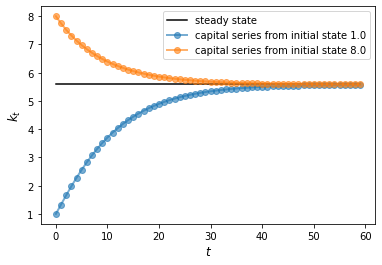

In [16]:
s1 = Solow()
s2 = Solow(k=8.0)

T = 60
fig, ax = plt.subplots()

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.6, label=lb)
ax.set_ylabel('$k_{t}$', fontsize=12)
ax.set_xlabel('$t$', fontsize=12)
ax.legend()
plt.show()

In [17]:
a = 1

@jit
def add_a(x):
    return a + x

print(add_a(10))

11


In [18]:
a = 2

print(add_a(10))

11


In [19]:
from random import uniform

@njit
def calculate_pi(n=1_000_000):
    count = 0
    for i in range(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1

    area_estimate = count / n
    return area_estimate * 4  # dividing by radius**2

In [20]:
%time calculate_pi()

CPU times: user 320 ms, sys: 84 µs, total: 320 ms
Wall time: 321 ms


3.142664

In [21]:
%time calculate_pi()

CPU times: user 18.4 ms, sys: 0 ns, total: 18.4 ms
Wall time: 18.3 ms


3.139372

In [22]:
p, q = 0.1, 0.2  # Prob of leaving low and high state respectively

In [23]:
def compute_series(n):
    x = np.empty(n, dtype=np.int_)
    x[0] = 1  # Start in state 1
    U = np.random.uniform(0, 1, size=n)
    for t in range(1, n):
        current_x = x[t-1]
        if current_x == 0:
            x[t] = U[t] < p
        else:
            x[t] = U[t] > q
    return x

In [24]:
n = 1_000_000
x = compute_series(n)
print(np.mean(x == 0))  # Fraction of time x is in state 0

0.667851


In [25]:
qe.tic()
compute_series(n)
qe.toc()

TOC: Elapsed: 0:00:1.03


1.0379202365875244

In [26]:
from numba import jit

compute_series_numba = jit(compute_series)

In [27]:
x = compute_series_numba(n)
print(np.mean(x == 0))

0.666681


In [28]:
qe.tic()
compute_series_numba(n)
qe.toc()

TOC: Elapsed: 0:00:0.01


0.015472173690795898